<a href="https://colab.research.google.com/github/Mohammad-Amin-Jenadele/gnn-graph-classification/blob/dev/GNN_Graph_classification_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and packages

In [1]:
# Downgrading PyTorch for compatibility with OGB library
! pip install torch_geometric ogb torch==2.5.1 torchvision torchaudio --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.1 MB/s eta 0:00:00


In [67]:
import numpy as np
import pandas as pd
import torch_geometric
import random
from torch_geometric.utils import to_networkx
import networkx as nx
import torch
import torch.nn.functional as F
from ogb.graphproppred import PygGraphPropPredDataset
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch_geometric.nn import GCNConv, GINEConv, GATv2Conv
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import matplotlib.pyplot as plt



# Setting configs and hyperparameters

In [7]:
# Choosing device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

device: cpu


# Data loading and preprocessing

# 📘 OGB MolHIV Dataset (Raw)

The dataset **ogbg-molhiv** consists of **41,127 graphs (molecules)**.  
Each molecule is labeled **0 or 1**, indicating whether it inhibits HIV replication (**1 = active**, **0 = inactive**).

---

## 🔹 Graph structure

- **Nodes = atoms**  
  Each node has **9 features**, representing atom properties such as:
  - Atomic number  
  - Formal charge  
  - Aromaticity  
  - Chirality  
  - Degree  
  - ... and more  

- **Edges = bonds**  
  Each edge has **3 features**, representing bond properties such as:
  - Bond type (single, double, aromatic, etc.)  
  - Bond stereochemistry  
  - Whether the bond is conjugated  

---

## 🔹 Raw CSV files

### 1. `node-feat.csv.gz`
- Shape: **(total_nodes, 9)**  
- Each row = **one atom (node)**  
- Columns = numerical features describing the atom (atomic number, chirality, formal charge, hybridization, aromaticity, etc.)  
- The rows are grouped by graph: first all nodes of graph 0, then graph 1, etc.  

---

### 2. `edge-feat.csv.gz`
- Shape: **(total_edges, 3)**  
- Each row = **one bond (edge)**  
- Columns = numerical features describing the bond:  
  - Bond type (single/double/triple/aromatic)  
  - Bond stereochemistry (e.g., cis/trans)  
  - Conjugation flag (0/1)  
- The rows are aligned with `edge.csv.gz` (row *i* in `edge-feat.csv.gz` corresponds to edge *i* in `edge.csv.gz`).  

---

### 3. `edge.csv.gz`
- Shape: **(total_edges, 2)**  
- Each row = **a directed edge** represented as `[src, dst]` (node indices).  
- Since bonds are undirected, each bond appears **twice**: once as `[u, v]` and once as `[v, u]`.  
- Indices are **local to the graph** (reset per molecule).  

---

### 4. `graph-label.csv.gz`
- Shape: **(num_graphs, 1)**  
- Each row = binary label (0 = inactive, 1 = active).  
- Tells whether the molecule inhibits HIV replication.  

---

### 5. `num-node-list.csv.gz`
- Shape: **(num_graphs, 1)**  
- Each row = number of nodes (atoms) in that graph (molecule).  
- Used to split the long `node-feat.csv.gz` into per-graph chunks.  

---

### 6. `num-edge-list.csv.gz`
- Shape: **(num_graphs, 1)**  
- Each row = number of edges (bonds) in that graph (molecule).  
- Used to split the long `edge.csv.gz` and `edge-feat.csv.gz` into per-graph chunks.  

---


In [8]:
# Load the dataset
dataset = PygGraphPropPredDataset(name='ogbg-molhiv' , root = '/content/')

Downloaded 0.00 GB: 100%|██████████| 3/3 [00:00<00:00,  9.23it/s]
Processing...


Extracting /content/hiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 41127/41127 [00:01<00:00, 39593.23it/s]


Converting graphs into PyG objects...


100%|██████████| 41127/41127 [00:01<00:00, 21350.93it/s]


Saving...


Done!
/usr/local/lib/python3.12/dist-packages/ogb/graphproppred/dataset_pyg.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.pro

In [10]:
# preprocessing the raw data
edge_feat_df = pd.read_csv('/content/ogbg_molhiv/raw/edge-feat.csv.gz' , compression = 'gzip', header = None)
edge_df = pd.read_csv('/content/ogbg_molhiv/raw/edge.csv.gz' , compression = 'gzip', header = None)
graph_label_df = pd.read_csv('/content/ogbg_molhiv/raw/graph-label.csv.gz' , compression = 'gzip', header = None)
node_feat_df = pd.read_csv('/content/ogbg_molhiv/raw/node-feat.csv.gz' , compression = 'gzip', header = None)
num_edge_list_df = pd.read_csv('/content/ogbg_molhiv/raw/num-edge-list.csv.gz' , compression = 'gzip', header = None)
num_node_list_df = pd.read_csv('/content/ogbg_molhiv/raw/num-node-list.csv.gz' , compression = 'gzip', header = None)

In [11]:
edge_feat_df

,0,1,2
0,0,0,0
1,0,0,0
2,1,0,0
3,0,0,0
4,0,0,0
...,...,...,...
1129683,3,0,1
1129684,3,0,1
1129685,3,0,1
1129686,3,0,1


In [12]:
edge_df

,0,1
0,0,1
1,1,2
2,2,3
3,3,4
4,4,5
...,...,...
1129683,29,36
1129684,21,7
1129685,36,22
1129686,20,15


In [13]:
graph_label_df

,0
0,0
1,0
2,0
3,0
4,0
...,...
41122,0
41123,0
41124,0
41125,0


In [14]:
node_feat_df

,0,1,2,3,4,5,6,7,8
0,5,0,4,5,3,0,2,0,0
1,5,0,4,5,2,0,2,0,0
2,5,0,3,5,0,0,1,0,1
3,7,0,2,6,0,0,1,0,1
4,28,0,4,2,0,0,5,0,1
...,...,...,...,...,...,...,...,...,...
1049158,5,0,3,5,0,0,1,1,1
1049159,5,0,4,5,3,0,2,0,0
1049160,6,0,2,5,0,0,1,1,1
1049161,7,0,2,5,0,0,1,1,1


In [15]:
num_edge_list_df

,0
0,20
1,44
2,24
3,25
4,9
...,...
41122,32
41123,42
41124,38
41125,38


In [16]:
num_node_list_df

,0
0,19
1,39
2,21
3,24
4,10
...,...
41122,28
41123,36
41124,33
41125,33


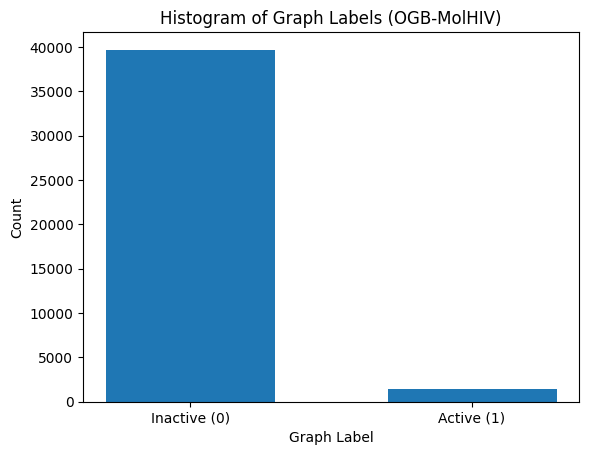

In [17]:
# Count labels
counts = graph_label_df[0].value_counts().sort_index()
# Plot as bar chart
plt.bar([0, 1], counts, width=0.6)
plt.xticks([0, 1], ["Inactive (0)", "Active (1)"])
plt.xlabel("Graph Label")
plt.ylabel("Count")
plt.title("Histogram of Graph Labels (OGB-MolHIV)")
plt.show()

## Loading the data in pytorch geometric format

In [54]:
nodes, edges, edge_features = [], [], []

# Process nodes
node_start = 0
for num_nodes in num_node_list_df[0]:
    node_end = node_start + num_nodes
    nodes.append(node_feat_df.iloc[node_start:node_end, :])
    node_start = node_end  # update for next graph

# Process edges and edge features
edge_start = 0
for num_edges in num_edge_list_df[0]:
    edge_end = edge_start + num_edges
    edges.append(edge_df.iloc[edge_start:edge_end, :])
    edge_features.append(edge_feat_df.iloc[edge_start:edge_end, :])
    edge_start = edge_end

# Create PyG graphs
graphs = []
for i in range(len(graph_label_df)):
    g = Data(
        x=torch.tensor(nodes[i].values, dtype=torch.float),
        edge_index=torch.tensor(edges[i].values, dtype=torch.long).t().contiguous(),
        edge_attr=torch.tensor(edge_features[i].values, dtype=torch.float),
        y=torch.tensor(graph_label_df.iloc[i].values, dtype=torch.float),
    )
    g.graph_id = i
    graphs.append(g)

In [55]:
print(len(graphs))

41127


## Visualizing Some graphs

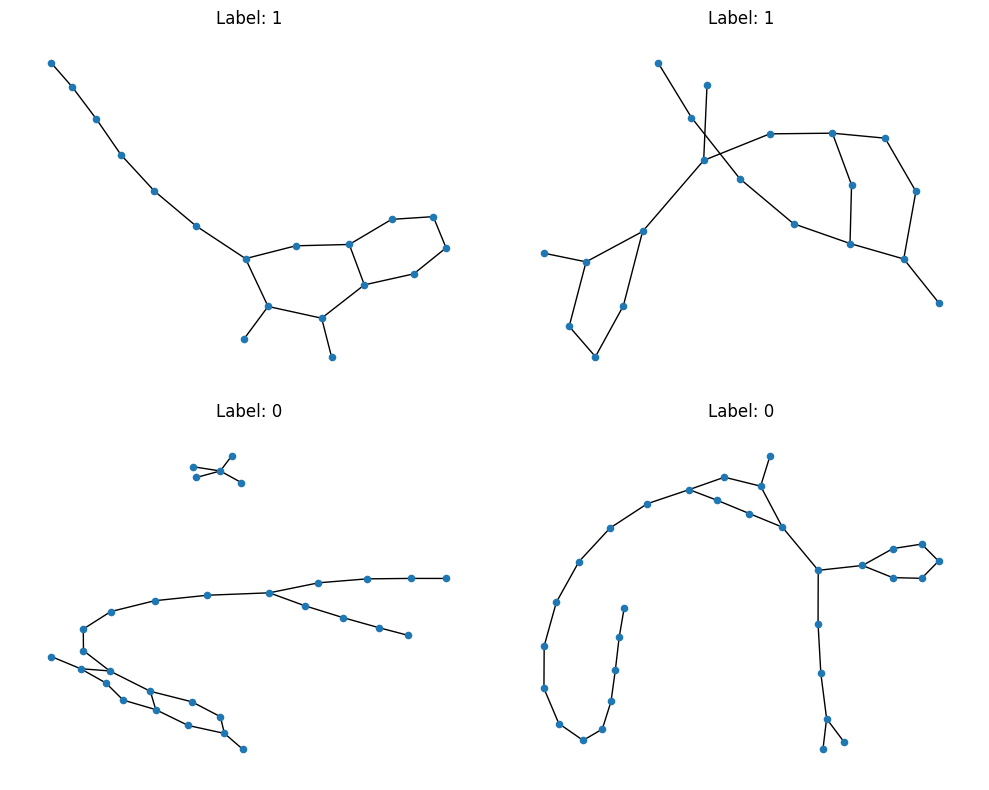

In [76]:
# Separate graphs by label
graphs_label1 = [g for g in graphs if int(g.y.item()) == 1]
graphs_label0 = [g for g in graphs if int(g.y.item()) == 0]

# Randomly choose 2 graphs from each group
chosen_graphs = random.sample(graphs_label1, 2) + random.sample(graphs_label0, 2)

# Plot them (2x2 grid)
plt.figure(figsize=(10, 8))
for i, graph in enumerate(chosen_graphs, 1):
    G = to_networkx(graph, to_undirected=True)
    plt.subplot(2, 2, i)
    nx.draw(G, node_size=20, with_labels=False)
    plt.title(f"Label: {int(graph.y.item())}")
plt.tight_layout()
plt.show()